# How to make a search engine on Movies Description

In this notebook, you will learn how to :

1. [Create a Doc2Vec model that represents words and documents into numerical vectors](#creating)

2. [Find words related to other words](#words)
3. [Find the document that has the closest meaning to a list of key words like in a search engine](#docs)

4. [Create a TF-IDF search engine](#tfidf)



<div class="alert alert-warning">
To run this notebook, you will need :
<ul>
<li>to run on **python 3.6.2**</li>
<li>to have **gensim** installed. Run '**pip install gensim**' in the python environment you are using for this notebook.</li>
<li>to have **langdetect** installed. Run '**pip install langdetect**' in the python environment you are using for this notebook.</li>
</ul>

</div>

We will start by importing what we need and downloading the files with the movies description.

The dataset comes from a kaggle dataset : https://www.kaggle.com/rounakbanik/the-movies-dataset/data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from gensim.models import Doc2Vec
from collections import namedtuple
import gensim.utils
from langdetect import detect
import re
import string

C:\Users\Paul\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
imdbdata=pd.read_csv('movies.csv')
data = np.array(imdbdata.overview)
titles=np.array(imdbdata.original_title)

imdbdata.head()

,overview,original_title
0,"Led by Woody, Andy's toys live happily in his ...",Toy Story
1,When siblings Judy and Peter discover an encha...,Jumanji
2,A family wedding reignites the ancient feud be...,Grumpier Old Men
3,"Cheated on, mistreated and stepped on, the wom...",Waiting to Exhale
4,Just when George Banks has recovered from his ...,Father of the Bride Part II


## Text preprocessing

In order to build the doc2vec model we need to clean the data that we have. We will remove text that are not string, that are too short and that are not written in english.
Then, we will remove punctuation, and lowercase every word.
We will build the list **alldocs** that contains every documents cleaned.

In [3]:
SentimentDocument = namedtuple('SentimentDocument', 'words tags title original_number')
n=0
alldocs = []  # Will hold all docs in original order

regex = re.compile('[%s]' % re.escape(string.punctuation)) #to remove punctuation

for line_no, line in enumerate(data):
    if (type(line)==str):
        if (len(line)>150):
            if (detect(line) == 'en') :
                line = regex.sub('', line)
                tokens = gensim.utils.to_unicode(line).lower().split()
                words = tokens[0:]
                tags = [n]
                title = titles[line_no]
                alldocs.append(SentimentDocument(words, tags, title, line_no))
                n=n+1    

Some insights on the dataset :

Number of Documents :  34180
Mean length of documents :  65.9078115857


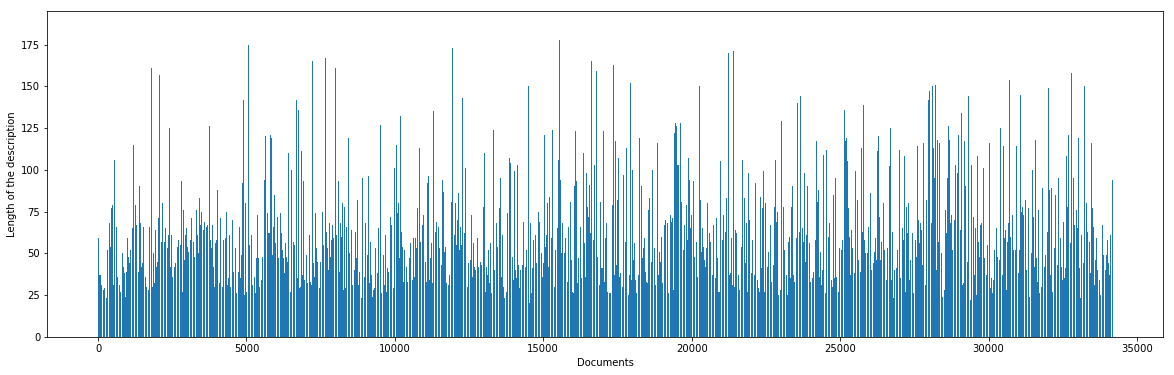

In [4]:
l = []
for doc in alldocs:
    l.append(len(doc.words))

print('Number of Documents : ', len(alldocs))
print('Mean length of documents : ', np.mean(l))

plt.figure (figsize=(20, 6))
plt.bar(range(0, len(l)), l)
plt.xlabel('Documents')
plt.ylabel('Length of the description')

In [5]:
# An example of how the list alldocs is build

index = 0
doc = alldocs[index]
print(doc, '\n')
print(data[doc.original_number])

SentimentDocument(words=['led', 'by', 'woody', 'andys', 'toys', 'live', 'happily', 'in', 'his', 'room', 'until', 'andys', 'birthday', 'brings', 'buzz', 'lightyear', 'onto', 'the', 'scene', 'afraid', 'of', 'losing', 'his', 'place', 'in', 'andys', 'heart', 'woody', 'plots', 'against', 'buzz', 'but', 'when', 'circumstances', 'separate', 'buzz', 'and', 'woody', 'from', 'their', 'owner', 'the', 'duo', 'eventually', 'learns', 'to', 'put', 'aside', 'their', 'differences'], tags=[0], title='Toy Story', original_number=0) 

Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.


## <a id="creating"></a> Creating and training the Doc2Vec model

We create the Distributed Memory model with a size of 300 ( that means that the vecors will be of size 300). The window size is 10. We do not take in account words that are seen less than 10 times in the entire corpus with the variable *min_count*. Setting the variable *dbow_words* to 1 means that we are also training to represents words with numerical vectors.

We then train our model over 100 epochs with a lerning rate of 0.01.

Full documentation can be found here :
<li> gensim : https://radimrehurek.com/gensim/ </li>
<li> Doc2Vec : https://radimrehurek.com/gensim/models/doc2vec.html </li>
<li> A great article introducing the concepts behind Doc2Vec : https://medium.com/scaleabout/a-gentle-introduction-to-doc2vec-db3e8c0cce5e </li>
<li> Detailed scientific paper : https://cs.stanford.edu/~quocle/paragraph_vector.pdf </li>


In [6]:
# PV-DM
model = Doc2Vec(dm=1, size=300,window=10,hs=0,min_count=10,dbow_words=1,sample=1e-5)

# build the vocabulary 
model.build_vocab(alldocs)

In [7]:
# PV-DM
model = Doc2Vec(dm=1, size=100,window=10,hs=0,min_count=10,dbow_words=1,sample=1e-5, dm_mean=1)

# build the vocabulary 
model.build_vocab(alldocs)

In [8]:
model.train(alldocs, total_examples=model.corpus_count, epochs=100, start_alpha=0.01, end_alpha=0.01)

61855563

We can save and load models with the lines below.

In [9]:
model.save("model")
#Doc2Vec.load("model")

## <a id="words"></a>Evaluating words embedding

We will try to evaluate our model with some examples by showing the closest words to the words love, war and space.

As the process of training a neural network does not always come to the same model, if the results do not make sense, you might consider creating the model and training it again.



In [10]:
model.wv.most_similar_cosmul(positive = ["love"])

[('falls', 0.8801013231277466),
 ('fall', 0.854912281036377),
 ('falling', 0.8247562050819397),
 ('madly', 0.8246678709983826),
 ('unrequited', 0.7697283029556274),
 ('triangle', 0.7637508511543274),
 ('meets', 0.7580552101135254),
 ('blossom', 0.7565732598304749),
 ('marries', 0.7459118366241455),
 ('fallen', 0.74567711353302)]

In [11]:
model.wv.most_similar_cosmul(positive = ["war"])

[('ii', 0.923835813999176),
 ('civil', 0.8792981505393982),
 ('ww', 0.8355215191841125),
 ('vietnam', 0.8320338726043701),
 ('frontline', 0.829814612865448),
 ('soldier', 0.8267297148704529),
 ('during', 0.8063095211982727),
 ('stationed', 0.8055090308189392),
 ('trenches', 0.8053523898124695),
 ('soldiers', 0.801713764667511)]

In [12]:
model.wv.most_similar_cosmul(positive = ["space"])

[('mars', 0.9091245532035828),
 ('nasa', 0.8941714763641357),
 ('astronaut', 0.8928399085998535),
 ('asteroid', 0.8869292736053467),
 ('spacecraft', 0.8843206167221069),
 ('planet', 0.8804934620857239),
 ('astronauts', 0.8803018927574158),
 ('outer', 0.8802769184112549),
 ('earth', 0.8740312457084656),
 ('spaceship', 0.8737911581993103)]

The cell below show that the relationship of gender is understood by the model as we have the equation ** man - woman = king - queen**

In [13]:
model.wv.most_similar_cosmul(negative = ["man"], positive = ["king","woman"])

[('crowned', 0.8636603355407715),
 ('princess', 0.8592969179153442),
 ('palace', 0.8541278839111328),
 ('stepping', 0.845645546913147),
 ('queen', 0.8434802293777466),
 ('dartagnan', 0.8404666185379028),
 ('throne', 0.817885160446167),
 ('frances', 0.8175328969955444),
 ('stepmother', 0.815171480178833),
 ('empress', 0.8079445958137512)]

The results on the word embeddings are satisfying as we have coherent outputs.

## <a id="docs"></a>Evaluating documents embedding

We will evaluate our model of documents embedding with some examples by showing the closest documents to key words ( here called tokens). We expect the documents to have similar meanings than the key words. In this way, the model act as a search engine.

In [14]:
# Closest document to the word "war"

tokens = "war"

new_vector = model.infer_vector(tokens.split() ,alpha=0.001 ,steps = 5)
tagsim = model.docvecs.most_similar([new_vector])[0]

docsim = alldocs[tagsim[0] ]

print("Document : ", data[docsim.original_number], "\n")
print("Titre : ", docsim.title)
print("Distance : ", tagsim[1])

Document :  Roger, son of a farmer, wants to be a boxer, and gets his chance by filling in for a boxer's sparring partner. However, Roger does not know how to box and reads a rule book while in the ring. 

Titre :  Soigne ton Gauche
Distance :  0.31606847047805786


We show the closest document to key words, the farest document and a document in the middle.

In [15]:
# Closest document to the word "love"

tokens = "love"

new_vector = model.infer_vector(tokens.split() ,alpha=0.001 ,steps = 5)
sims = model.docvecs.most_similar([new_vector], topn=model.docvecs.count) # get *all* similar documents

print("Most : " , data[alldocs[sims[0][0]].original_number], "\n") 
print("Median : " , data[alldocs[sims[17000][0]].original_number], "\n")
print("Least : " , data[alldocs[sims[-1][0]].original_number])

Most :  It's not easy being the most popular couple in high school. Adam and Amber are the golden pair of Gaitlin High and are very busy being cool. Yet somehow Adam finds time for extracurricular activities, like making-it with Gynger, a sophomore, in the bathroom of a local restaurant. Soon, Adam's tidy world starts to fall apart when he finds out Gynger is pregnant. An ambitious Assistant District Attorney decides to file charges against Adam. Trying to help, Adam's parents hire a third-rate attorney whose every move just makes matters worse! Jailbait is a wickedly funny look at how far some guys will go to score. Can Adam find a way to keep himself out of jail and his girlfriend by his side? Watch this hysterical teen comedy featuring a cool cast of young stars and a hip soundtrack. See what happens when hormones rage and you're under age!!! 

Median :  In this crazy, chaotic gospel of chance, aspiring filmmakers Chris Stamp and Kit Lambert set out to search for a subject for their

In this example, in terms of reviewer tone, movie genre, etc... the MOST cosine-similar documents seem more like the key words than the MEDIAN or LEAST

In [16]:
doc = np.random.randint(model.docvecs.count)

sims = model.docvecs.most_similar(doc, topn=model.docvecs.count) # get *all* similar documents

print("Target : ", data[alldocs[doc] .original_number], "\n" )
print("Most : " , data[alldocs[sims[0][0]].original_number], "\n")
print("Median : " , data[alldocs[sims[34000][0]].original_number], "\n")
print("Least : " , data[alldocs[sims[-1][0]].original_number])


Target :  Hannie enlists the aid of bounty hunter Tom Price to teach her how to be a gunfighter so she can hunt down the 3 men who killed her husband and raped her. 

Most :  A woman framed for her husband's murder suspects he is still alive; as she has already been tried for the crime, she can't be re-prosecuted if she finds and kills him. 

Median :  Record store clerk Nick Brady begins to experience strange visions from an entity he calls VALIS that cause him to uproot his family and move to Los Angeles where he becomes a successful music company executive. Nick finds himself drawn into a dangerous political-mystical conspiracy of cosmic proportions. 

Least :  A company of Spanish movie makers leaves Franco's Spain and moves to Hitler's Germany to make a film in co-production. Soon some problems start to arise...


Usually the MOST cosine-similar documents usually seem more like the TARGET than the MEDIAN or LEAST

 ## Pre-trained word embeddings
 
 It is possible to use pre-trained word embeddings for your model. Indeed, there is a word2vec model available here (https://code.google.com/archive/p/word2vec). This model is trained by google but might not be well suited for the problem you want to solve. 

In [17]:
# PV-DBOW (with negative sampling)
model_pre_trained = Doc2Vec(dm=0,size=300, window=15,hs=0,negative=5,min_count=10,dbow_words=1,sample=1e-5)

# build the vocabulary 
model_pre_trained.build_vocab(alldocs)

# use pre-trained word vectors from google
model_pre_trained.intersect_word2vec_format('../input/google-doc2vec/GoogleNews-vectors-negative300.bin', binary=True)

FileNotFoundError: [Errno 2] No such file or directory: '../input/google-doc2vec/GoogleNews-vectors-negative300.bin'

In [ ]:
model_pre_trained.train(alldocs, total_examples=model.corpus_count, epochs=100)

## <a id="tfidf"></a>Creating the TF-IDF model

we create the TF-IDF model from the list alldocs with the module TfidfModel from gensim.


Full documentation can be found here :
<li> gensim : https://radimrehurek.com/gensim/ </li>
<li> Tf-Idf : https://radimrehurek.com/gensim/models/tfidfmodel.html </li>

In [ ]:
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from gensim import similarities 

dct = Dictionary(doc.words for doc in alldocs)  # fit dictionary
corpus = [dct.doc2bow(line.words) for line in alldocs]  # convert dataset to BoW format
model_tfidf = TfidfModel(corpus)  # fit model

In [ ]:
# for example 
 
index = 0
print("Document ",index, " : ", data[alldocs[index].original_number] ) 
print("Bag of words representation of document ", index, " : ", corpus[index])

## Creating Similarity matrix between a list of key words and all the documents

We create a matrix similarity thet represents the similarity between the list of key words and the documents.

In [ ]:
#Create similarity matrix between doc and tokens
tokens = "love".split()
index = similarities.MatrixSimilarity([dct.doc2bow(tokens)],num_features=len(dct))

We just use the document with the higher score of similarity.

In [ ]:
similarity=np.zeros((len(alldocs)))
maxsim = 0
for id, doc in enumerate(alldocs):
    similarity[id] = index[dct.doc2bow(doc.words)]
    
docsim= alldocs[np.argmax(similarity)] 
print(data[docsim.original_number])
print(tagsim)
print(docsim.title)